# Assignment Part - I

# Advanced Regression model - Surprise housing assignment

A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia. The data is provided in the CSV file below.
The company is looking at prospective properties to buy to enter the market. You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.

The company wants to know:
-  Which variables are significant in predicting the price of a house, and
-  How well those variables describe the price of a house.

Also, determine the optimal value of lambda for ridge and lasso regression.

### Business Goal

- **<font color=blue>You are required to model the price of houses with the available independent variables. This model will then be used by the management to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns. Further, the model will be a good way for management to understand the pricing dynamics of a new market.</font>**

## Steps
- <b>Step 1</b>: Data understanding
- <b>Step 2</b>: Data cleansing
- <b>Step 3</b>: EDA/Data Visualization
- <b>Step 4</b>: Model Building
- <b>Step 5</b>: Conclusion

In [1532]:
#Import all required modules

import pandas as pd
pd.set_option("display.max_columns", None)

from pandas.api.types import is_object_dtype
from pandas.api.types import is_numeric_dtype
from pandas.api.types import is_datetime64_ns_dtype

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:,.2f}'.format

from IPython.display import display, HTML
pd.options.display.float_format = '{:,.2f}'.format

#Model and preprocessing  frameworks
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, train_test_split
from sklearn.compose import make_column_transformer,ColumnTransformer
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression,Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import set_config
set_config(display='diagram')

## Common Code

In [1533]:
def data_summary(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Null/NaNs'] = df.isnull().sum().values
    summary['Null/NaNs %'] = np.round((df.isnull().sum().values/df.shape[0])*100, decimals = 2)
    summary['Unique values'] = df.nunique().values
    summary['Unique values %'] = np.round((df.nunique().values/df.shape[0])*100, decimals = 2)
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values
    summary['Skewness'] = df.skew(axis = 1, skipna = True, numeric_only = True)
    summary['Kurtosis'] = df.kurt(axis = 1, skipna = True, numeric_only = True)
#    if data_dict.empty() == False:
#        summary['Description'] = summary.Name.apply(lambda x: data_dict[x])
    return summary

In [1534]:
def retrieve_value_counts(data):
    value_counts_frame = None
    for column in data.columns:
        if data[column].dtype == object :
            countsize = data[column].value_counts(dropna=False).size
            value_counts = pd.DataFrame(data[column].value_counts(dropna=False).reset_index())
            name_list = [column]*countsize
            value_counts['Name'] = name_list
            value_counts = value_counts.rename({'index':'Values', column:'ValueCount'}, axis=1)
            if value_counts_frame is None:
                value_counts_frame = pd.DataFrame(value_counts)
            else:    
                value_counts_frame= value_counts_frame.append(value_counts,ignore_index=True,sort=False)
        
            del value_counts
    value_counts_frame = value_counts_frame[['Name', 'Values', 'ValueCount']]        
    return(value_counts_frame)

In [1535]:
def plot_boxsubplots(var, target, data, fig_size):
    plt.figure(figsize=fig_size)
    sns.set(font_scale=2)
    size = len(var)
    maxcol = 3
    total_rows = int(size / maxcol) + (size % maxcol)
    for i in range(0,len(var)):
        plt.subplot(total_rows,maxcol,i+1)
        fig = sns.boxplot(x = data[var[i]], y = data[target], data = data, order = data[var[i]].value_counts().index)
        fig.set_xlabel(var[i], color='black',fontweight='bold')
        fig.set_ylabel(target, color='black',fontweight='bold')
    plt.show()

In [1536]:
def plot_distsubplots(var, data, fig_size):
    plt.figure(figsize=fig_size)
    sns.set(font_scale=2)
    size = len(var)
    maxcol = 3
    total_rows = int(size / maxcol) + (size % maxcol)
    for i in range(0,len(var)):
        plt.subplot(total_rows,maxcol,i+1)
        fig = sns.distplot(x = data[var[i]])
        fig.set_xlabel(var[i], color='black',fontweight='bold')
    plt.show()

In [1537]:
def plot_countsubplots(var, data, fig_size):
    plt.figure(figsize=fig_size)
    sns.set(font_scale=2)
    size = len(var)
    maxcol = 3
#    if()
    total_rows = int(size / maxcol) + (size % maxcol)
    for i in range(0,len(var)):
        plt.subplot(total_rows,maxcol,i+1)
        fig = sns.countplot(x = data[var[i]], data = data, order = data[var[i]].value_counts().index)
        fig.set_xlabel(var[i], color='black',fontweight='bold')
    plt.show()

In [1538]:
def plot_scattersubplots(var, target, data, fig_size):
    plt.figure(figsize=fig_size)
    sns.set(font_scale=2)
    size = len(var)
    maxcol = 3
#    if()
    total_rows = int(size / maxcol) + (size % maxcol)
    for i in range(0,len(var)):
        plt.subplot(total_rows,maxcol,i+1)
        fig = sns.scatterplot(x = data[var[i]], data = data, y=target)
        fig.set_xlabel(var[i], color='black',fontweight='bold')
        fig.set_ylabel(target, color='black',fontweight='bold')
    plt.show()

## Step 1&2: Data Understanding and data cleansing

In [1539]:
na_values = ["", 
             "#N/A", 
             "#N/A N/A", 
             "#NA", 
             "-1.#IND", 
             "-1.#QNAN", 
             "-NaN", 
             "-nan", 
             "1.#IND", 
             "1.#QNAN", 
             "<NA>", 
             "N/A", 
 #             "NA", 
             "NULL", 
             "NaN", 
             "n/a", 
             "nan", 
             "null"]
main_df = pd.read_csv('train.csv', na_values=na_values, keep_default_na=False)
main_df.head().style.background_gradient(cmap='PuBu')

In [1540]:
main_df.shape

(1460, 81)

In [1541]:
main_df.describe().T

count       mean       std       min        25%        50%  \
Id            1,460.00     730.50    421.61      1.00     365.75     730.50   
MSSubClass    1,460.00      56.90     42.30     20.00      20.00      50.00   
LotArea       1,460.00  10,516.83  9,981.26  1,300.00   7,553.50   9,478.50   
OverallQual   1,460.00       6.10      1.38      1.00       5.00       6.00   
OverallCond   1,460.00       5.58      1.11      1.00       5.00       5.00   
YearBuilt     1,460.00   1,971.27     30.20  1,872.00   1,954.00   1,973.00   
YearRemodAdd  1,460.00   1,984.87     20.65  1,950.00   1,967.00   1,994.00   
BsmtFinSF1    1,460.00     443.64    456.10      0.00       0.00     383.50   
BsmtFinSF2    1,460.00      46.55    161.32      0.00       0.00       0.00   
BsmtUnfSF     1,460.00     567.24    441.87      0.00     223.00     477.50   
TotalBsmtSF   1,460.00   1,057.43    438.71      0.00     795.75     991.50   
1stFlrSF      1,460.00   1,162.63    386.59    334.00     882.00   1,087.00   
2ndFlrSF      1,460.00     346.99    436.53      0.00       0.00       0.00   
LowQualFinSF  1,460.00       5.84     48.62      0.00       0.00       0.00   
GrLivArea     1,460.00   1,515.46    525.48    334.00   1,129.50   1,464.00   
BsmtFullBath  1,460.00       0.43      0.52      0.00       0.00       0.00   
BsmtHalfBath  1,460.00       0.06      0.24      0.00       0.00       0.00   
FullBath      1,460.00       1.57      0.55      0.00       1.00       2.00   
HalfBath      1,460.00       0.38      0.50      0.00       0.00       0.00   
BedroomAbvGr  1,460.00       2.87      0.82      0.00       2.00       3.00   
KitchenAbvGr  1,460.00       1.05      0.22      0.00       1.00       1.00   
TotRmsAbvGrd  1,460.00       6.52      1.63      2.00       5.00       6.00   
Fireplaces    1,460.00       0.61      0.64      0.00       0.00       1.00   
GarageCars    1,460.00       1.77      0.75      0.00       1.00       2.00   
GarageArea    1,460.00     472.98    213.80      0.00     334.50     480.00   
WoodDeckSF    1,460.00      94.24    125.34      0.00       0.00       0.00   
OpenPorchSF   1,460.00      46.66     66.26      0.00       0.00      25.00   
EnclosedPorch 1,460.00      21.95     61.12      0.00       0.00       0.00   
3SsnPorch     1,460.00       3.41     29.32      0.00       0.00       0.00   
ScreenPorch   1,460.00      15.06     55.76      0.00       0.00       0.00   
PoolArea      1,460.00       2.76     40.18      0.00       0.00       0.00   
MiscVal       1,460.00      43.49    496.12      0.00       0.00       0.00   
MoSold        1,460.00       6.32      2.70      1.00       5.00       6.00   
YrSold        1,460.00   2,007.82      1.33  2,006.00   2,007.00   2,008.00   
SalePrice     1,460.00 180,921.20 79,442.50 34,900.00 129,975.00 163,000.00   

                     75%        max  
Id              1,095.25   1,460.00  
MSSubClass         70.00     190.00  
LotArea        11,601.50 215,245.00  
OverallQual         7.00      10.00  
OverallCond         6.00       9.00  
YearBuilt       2,000.00   2,010.00  
YearRemodAdd    2,004.00   2,010.00  
BsmtFinSF1        712.25   5,644.00  
BsmtFinSF2          0.00   1,474.00  
BsmtUnfSF         808.00   2,336.00  
TotalBsmtSF     1,298.25   6,110.00  
1stFlrSF        1,391.25   4,692.00  
2ndFlrSF          728.00   2,065.00  
LowQualFinSF        0.00     572.00  
GrLivArea       1,776.75   5,642.00  
BsmtFullBath        1.00       3.00  
BsmtHalfBath        0.00       2.00  
FullBath            2.00       3.00  
HalfBath            1.00       2.00  
BedroomAbvGr        3.00       8.00  
KitchenAbvGr        1.00       3.00  
TotRmsAbvGrd        7.00      14.00  
Fireplaces          1.00       3.00  
GarageCars          2.00       4.00  
GarageArea        576.00   1,418.00  
WoodDeckSF        168.00     857.00  
OpenPorchSF        68.00     547.00  
EnclosedPorch       0.00     552.00  
3SsnPorch           0.00     508.00  
ScreenPorch         0.00     480

In [1542]:
main_df.describe(include='O').T.sort_values('freq',ascending=False).head(10)

count unique      top  freq
Utilities    1460      2   AllPub  1459
Street       1460      2     Pave  1454
PoolQC       1460      4       NA  1453
Condition2   1460      8     Norm  1445
RoofMatl     1460      8  CompShg  1434
Heating      1460      6     GasA  1428
MiscFeature  1460      5       NA  1406
LandSlope    1460      3      Gtl  1382
Alley        1460      3       NA  1369
CentralAir   1460      2        Y  1365

In [1543]:
#By looking at the data dcitionary provided, below is the list of the columns for which NA means nan/missing/null values.
#Separating these values as it is important step before proceeding with with the clean up
non_NA_cols = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'LotShape', 'LandContour', 'Utilities',
               'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
               'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrArea',
               'ExterQual', 'ExterCond', 'Foundation', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
               'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
               'BsmtHalfBath', 'FullBath', 'HalfBath', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 
               'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'PavedDrive', 'WoodDeckSF', 
               'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold',
               'SaleType', 'SaleCondition']

In [1544]:
#These are the columns manually collected from the data dictionary for 
#which the NA means the feature is not present and NA is a valid value and not missing value
valid_na_col = ['MiscFeature', 'Fence', 'PoolQC', 'GarageCond', 'GarageQual', 'GarageFinish', 'GarageType', 'FireplaceQu',
                'BsmtFinType2', 'BsmtFinType1', 'BsmtExposure', 'BsmtCond', 'BsmtQual', 'Alley']

In [1545]:
#Check if there are any overlapping columns to make sure that there is no error in manual list preparation 
#for valid NA values and columns for which NA is the NaN vlaue.
set(non_na_cols).intersection(set(valid_na_col))

set()

In [1546]:
#Adjusting the NA value based on the facts of NA representation after going through the data.
for col in non_na_cols:
    main_df[col] = main_df[col].apply(lambda x: None if x == 'NA' else x)

In [1547]:
#Adjusting the NA value based on the facts of NA representation after going through the data.
for col in valid_na_col:
    main_df[col] = main_df[col].apply(lambda x: 'Not present' if x == 'NA' else x)

In [1548]:
#Convert the year or month columns to date type 
year_columns = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']
for col in year_columns:
    main_df[col] = pd.to_datetime(main_df[col])
    
main_df.MoSold = pd.to_datetime(main_df.MoSold)

In [1549]:
main_df[year_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   YearBuilt     1460 non-null   datetime64[ns]
 1   YearRemodAdd  1460 non-null   datetime64[ns]
 2   GarageYrBlt   1379 non-null   datetime64[ns]
 3   YrSold        1460 non-null   datetime64[ns]
dtypes: datetime64[ns](4)
memory usage: 45.8 KB


In [1550]:
main_df[['MoSold']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   MoSold  1460 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 11.5 KB


In [1551]:
#The list is of the columns which are numerical as per the data dictionary. Cross verify these columns with actualy data
numeric_column_as_data_dict = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']
main_df[numeric_column_as_data_dict].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   LotFrontage    1201 non-null   object
 1   LotArea        1460 non-null   int64 
 2   MasVnrArea     1452 non-null   object
 3   BsmtFinSF1     1460 non-null   int64 
 4   BsmtFinSF2     1460 non-null   int64 
 5   BsmtUnfSF      1460 non-null   int64 
 6   TotalBsmtSF    1460 non-null   int64 
 7   1stFlrSF       1460 non-null   int64 
 8   2ndFlrSF       1460 non-null   int64 
 9   LowQualFinSF   1460 non-null   int64 
 10  GrLivArea      1460 non-null   int64 
 11  TotRmsAbvGrd   1460 non-null   int64 
 12  Fireplaces     1460 non-null   int64 
 13  GarageCars     1460 non-null   int64 
 14  GarageArea     1460 non-null   int64 
 15  WoodDeckSF     1460 non-null   int64 
 16  OpenPorchSF    1460 non-null   int64 
 17  EnclosedPorch  1460 non-null   int64 
 18  3SsnPorch      1460 non-null

In [1552]:
#Aligning the data type properly to ease the further processing
main_df.LotFrontage = pd.to_numeric(main_df.LotFrontage)
main_df.LotFrontage.describe()

count   1,201.00
mean       70.05
std        24.28
min        21.00
25%        59.00
50%        69.00
75%        80.00
max       313.00
Name: LotFrontage, dtype: float64

In [1553]:
#Aligning the data type properly to ease the further processing
main_df.MasVnrArea = pd.to_numeric(main_df.MasVnrArea)
main_df.MasVnrArea.describe()

count   1,452.00
mean      103.69
std       181.07
min         0.00
25%         0.00
50%         0.00
75%       166.00
max     1,600.00
Name: MasVnrArea, dtype: float64

In [1554]:
summary_df = data_summary(main_df)
summary_df.sort_values(by=['Unique values','Null/NaNs'], ascending=False).style.background_gradient(cmap='PuBu')

Dataset Shape: (1460, 81)


#### Observation/Conclusion
- <font color='blue'>The ID field has 100% unique values which are of no use for our model, hence dropping the field</font>
- <font color='blue'>The LotArea field has 73% unique values which are of no use for our model, hence dropping the field</font>
- <font color='blue'>The LotFrontage and GarageYrBlt fields have a few missing values as the quantity is low, will decide about the imputation in the model building phase</font>

In [1555]:
main_df = main_df.drop(summary_df[summary_df['Unique values %'] > 70].Name, axis=1)

In [1556]:
main_df.shape

(1460, 79)

In [1557]:
#Looking at the descriptive stats, we can safely drop the NaN rows.
#main_df = main_df.dropna()
#main_df.shape

In [1558]:
value_count_df = retrieve_value_counts(main_df)
value_count_df.style.background_gradient(cmap='PuBu')

In [1559]:
value_count_df[value_count_df.ValueCount >= main_df.shape[0]*75/100].sort_values(by='ValueCount',ascending=False).style.background_gradient(cmap='PuBu')

#### Observations

-  <font color='blue'>For above columns, the observations is that more than 75% of the values are of singular type.</font>

#### Conclusion
-  <font color='blue'>We need to further analyse the data in EDA to decide if further cleaing is requried or not and also to analyse the correlations.</font>

## Step 3: EDA/Data Visualization

In [1560]:
#Not distinguishing the date columns separately below to keep things simiple for EDA phase
object_cols = [col for col in main_df.columns if is_object_dtype(main_df[col])]
numeric_cols = main_df.columns.difference(object_cols)

print('==============================Object columns - ' + str(len(object_cols)) + '=====================================')
print(str(object_cols))
print('===============================Numeric columns - ' + str(len(numeric_cols)) + '====================================')
print(str(numeric_cols))
print('===========================================================================')

==============================Object columns - 43=====================================
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
===============================Numeric columns - 36====================================
Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
       'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars',
       'GarageYrBlt', 'GrLi

In [1561]:
main_df[numeric_cols].corr().style.background_gradient(cmap='coolwarm').set_precision(2)

In [1562]:
main_df.skew(axis=0).sort_values(ascending=False).head(5)

MiscVal        24.48
PoolArea       14.83
3SsnPorch      10.30
LowQualFinSF    9.01
KitchenAbvGr    4.49
dtype: float64

In [1563]:
main_df.kurt(axis=0).sort_values(ascending=False).head(5)

MiscVal        701.00
PoolArea       223.27
3SsnPorch      123.66
LowQualFinSF    83.23
KitchenAbvGr    21.53
dtype: float64

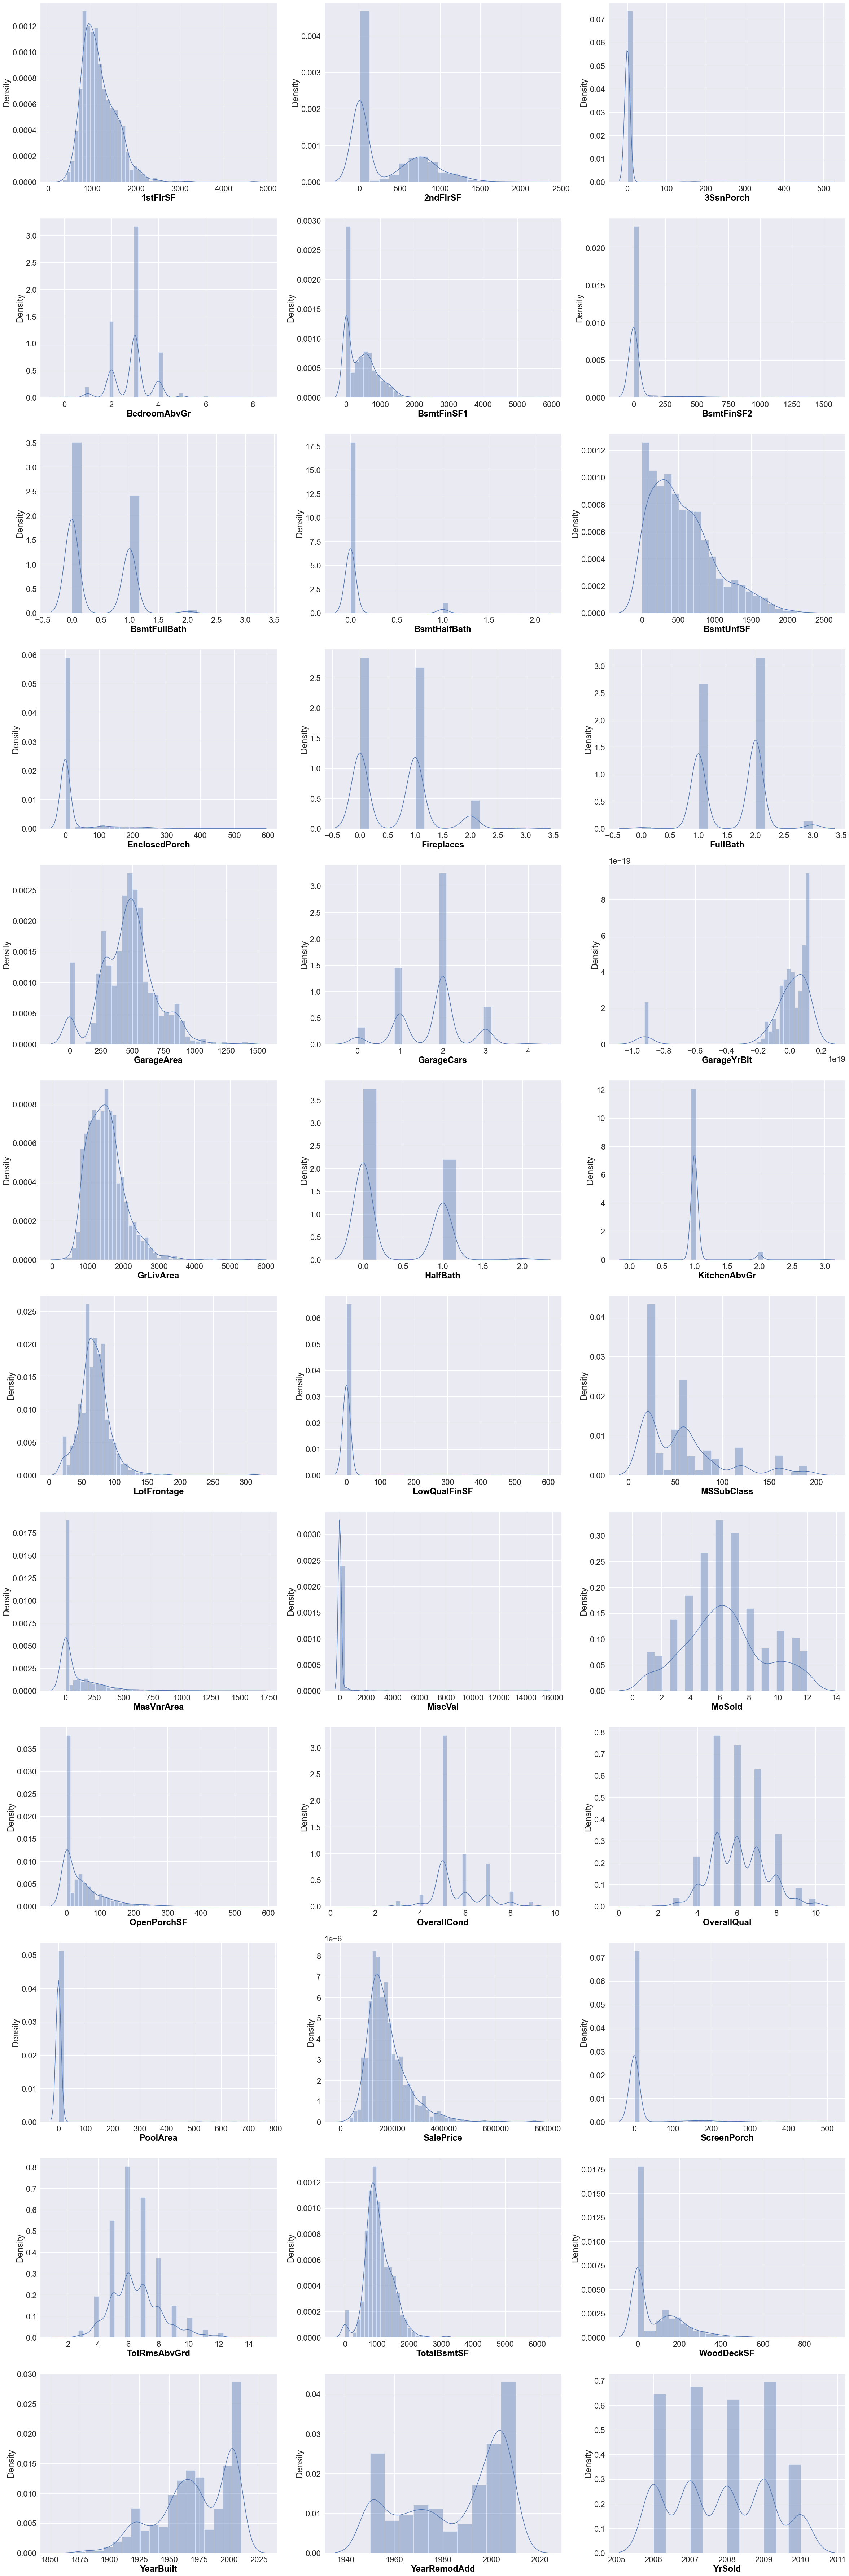

In [1564]:
plot_distsubplots(numeric_cols, main_df, fig_size=(40, 130))

#### Observations
- <font color='blue'>Most of numerical columns are skewed.</font>

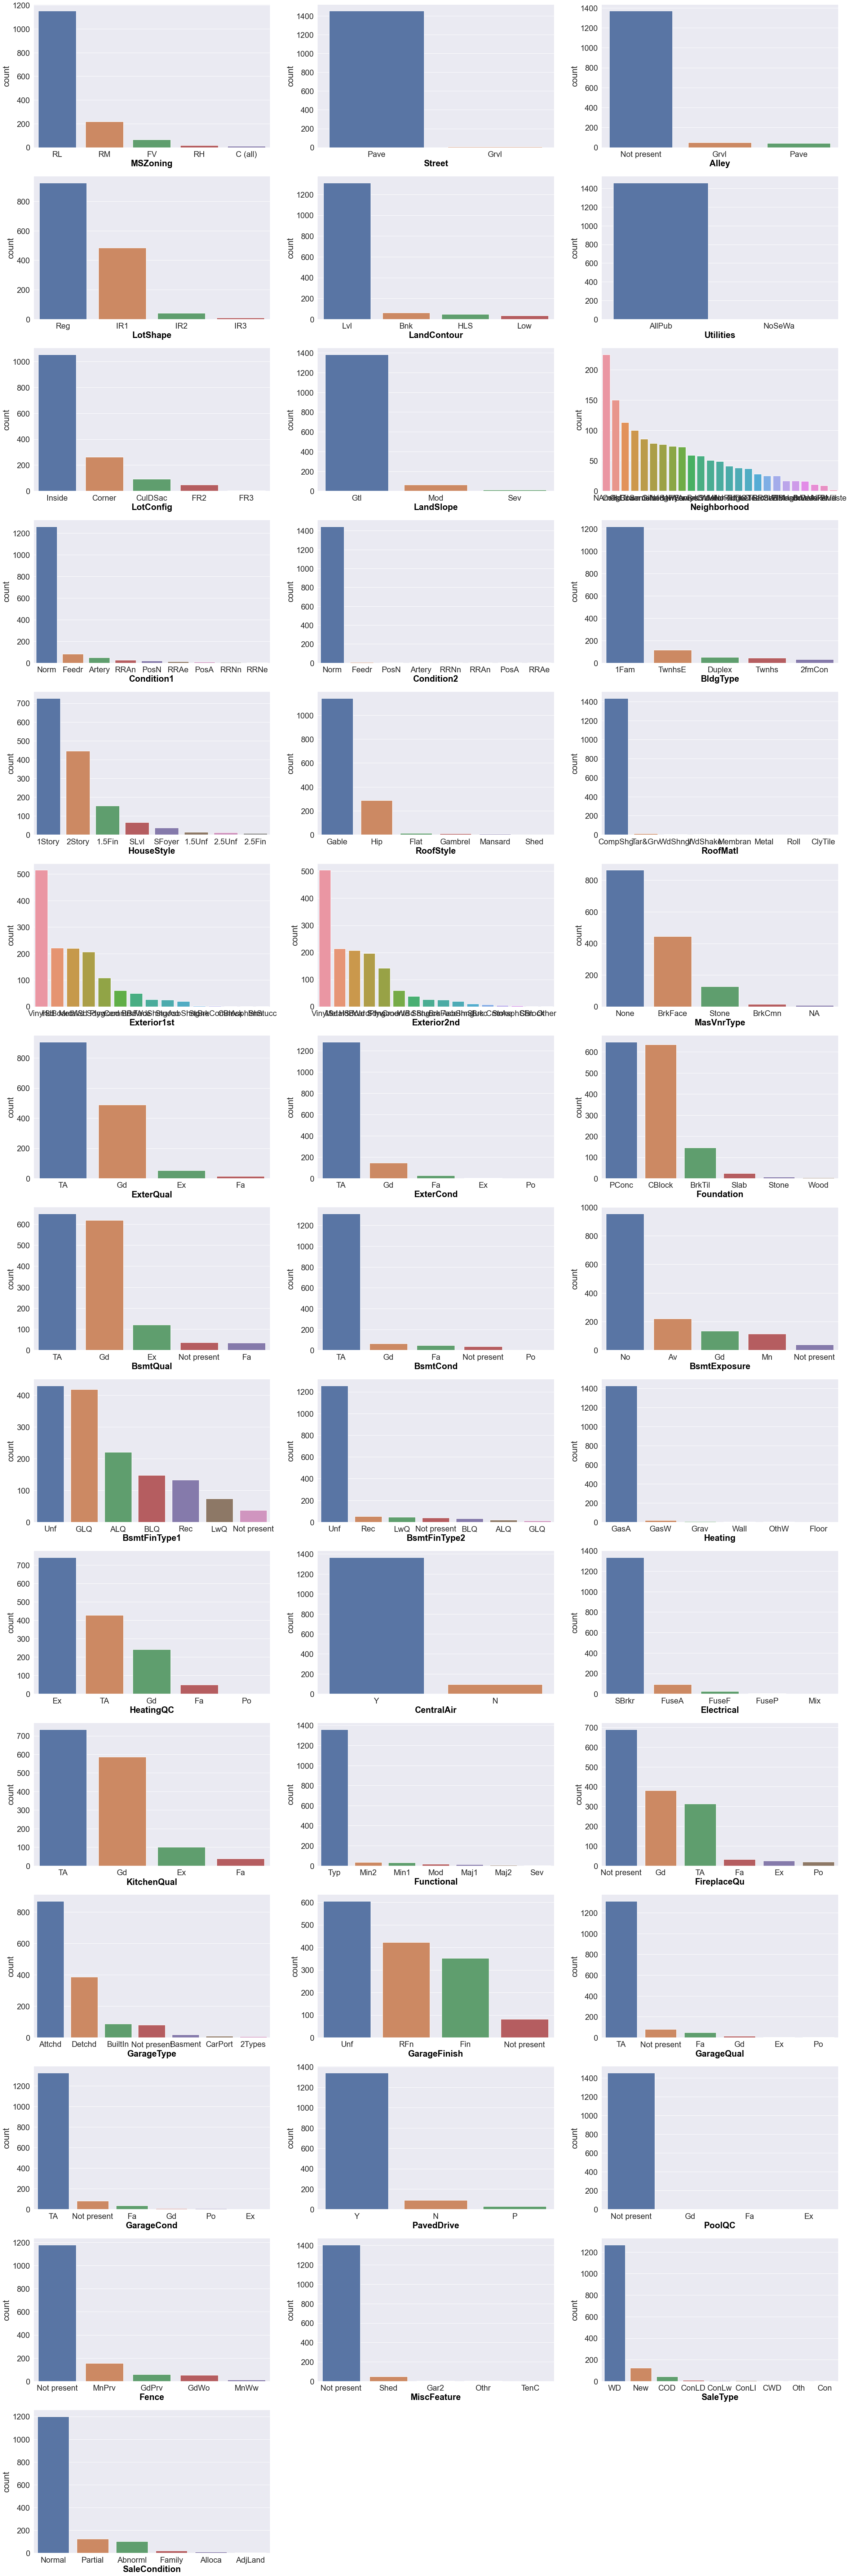

In [1565]:
plot_countsubplots(object_cols, main_df, fig_size=(40, 130))

#### Observations:
- <font color='blue'>Most of the categorical columns are also skewed</font>

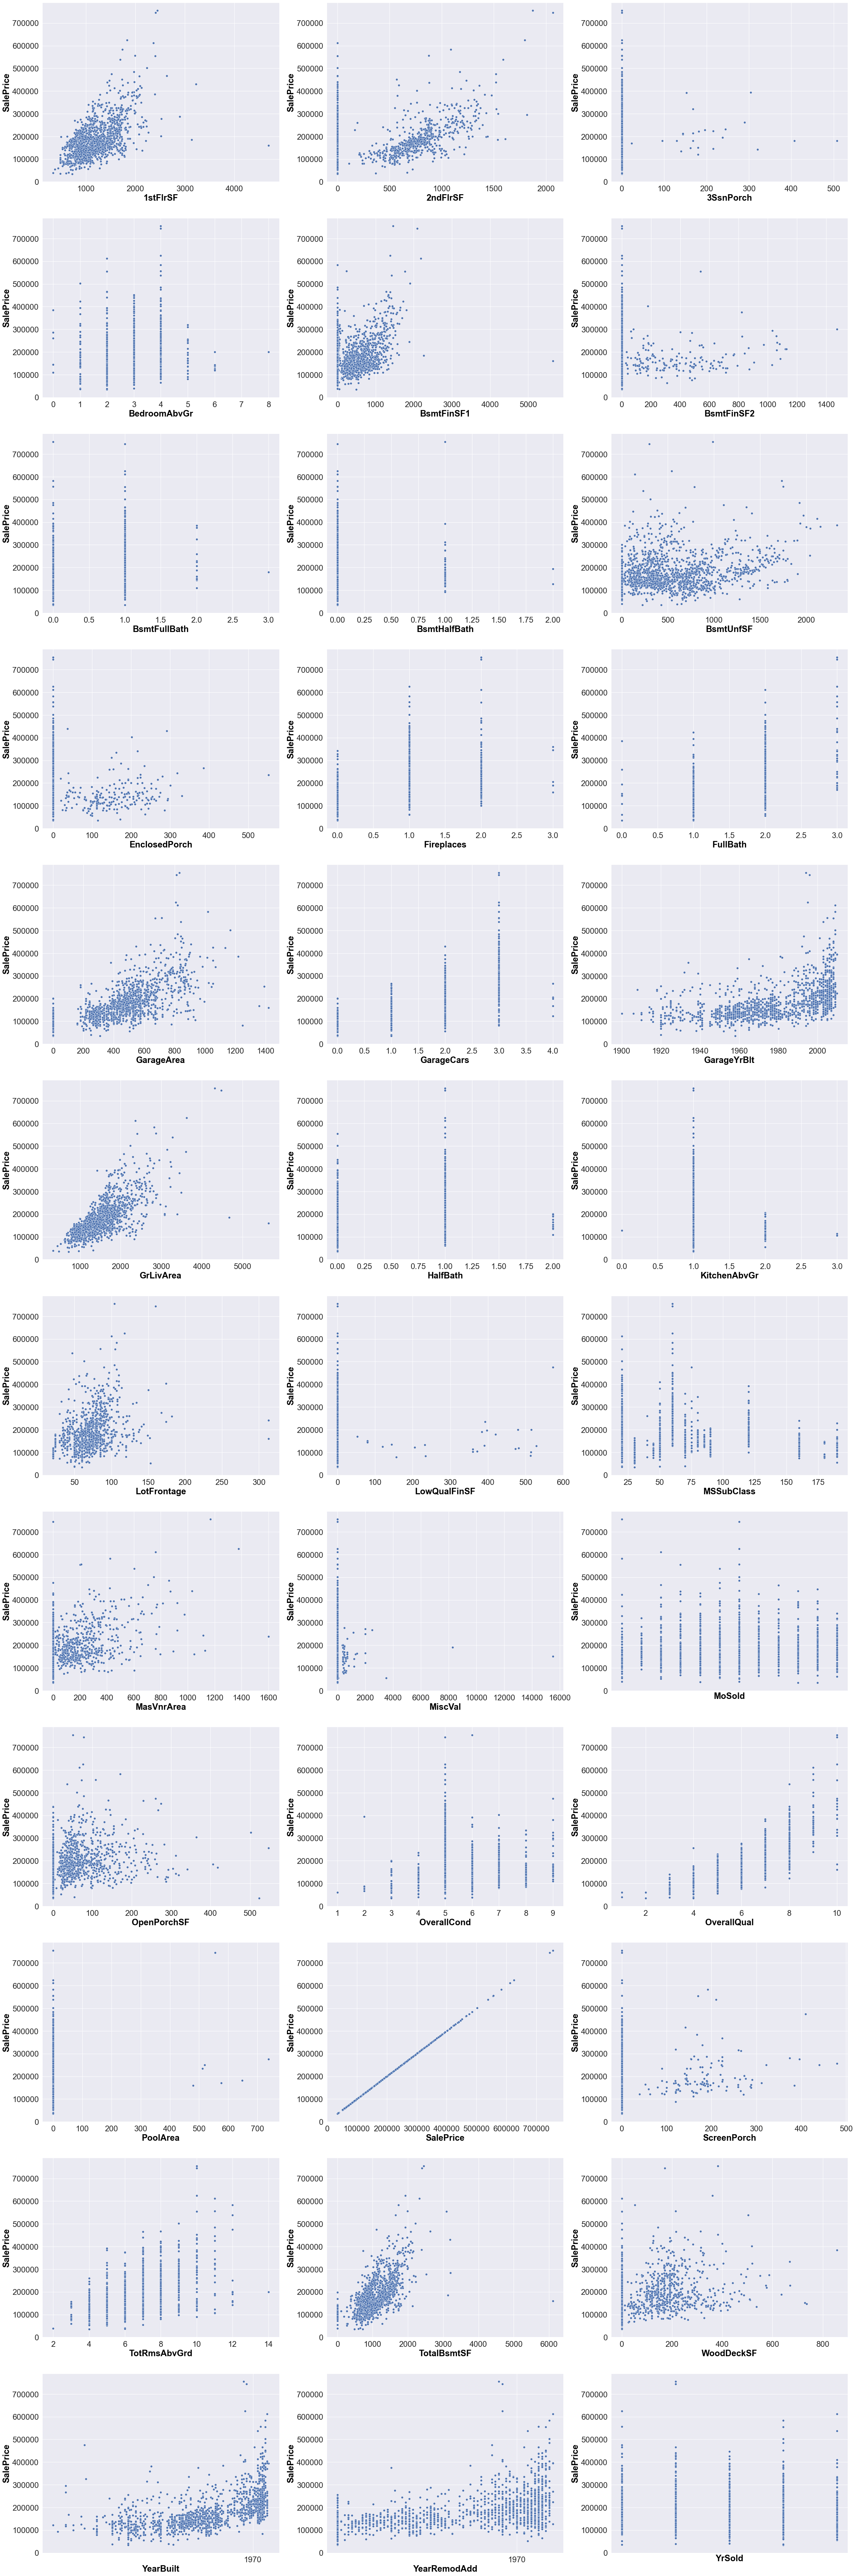

In [1566]:
plot_scattersubplots(numeric_cols, 'SalePrice', main_df, fig_size=(40, 130))

#### Observations
-  <font color='blue'>Most of hte numeric comulns does show somewhat linear relation with the target however data is scattered and shows several upper bound outliers</font>

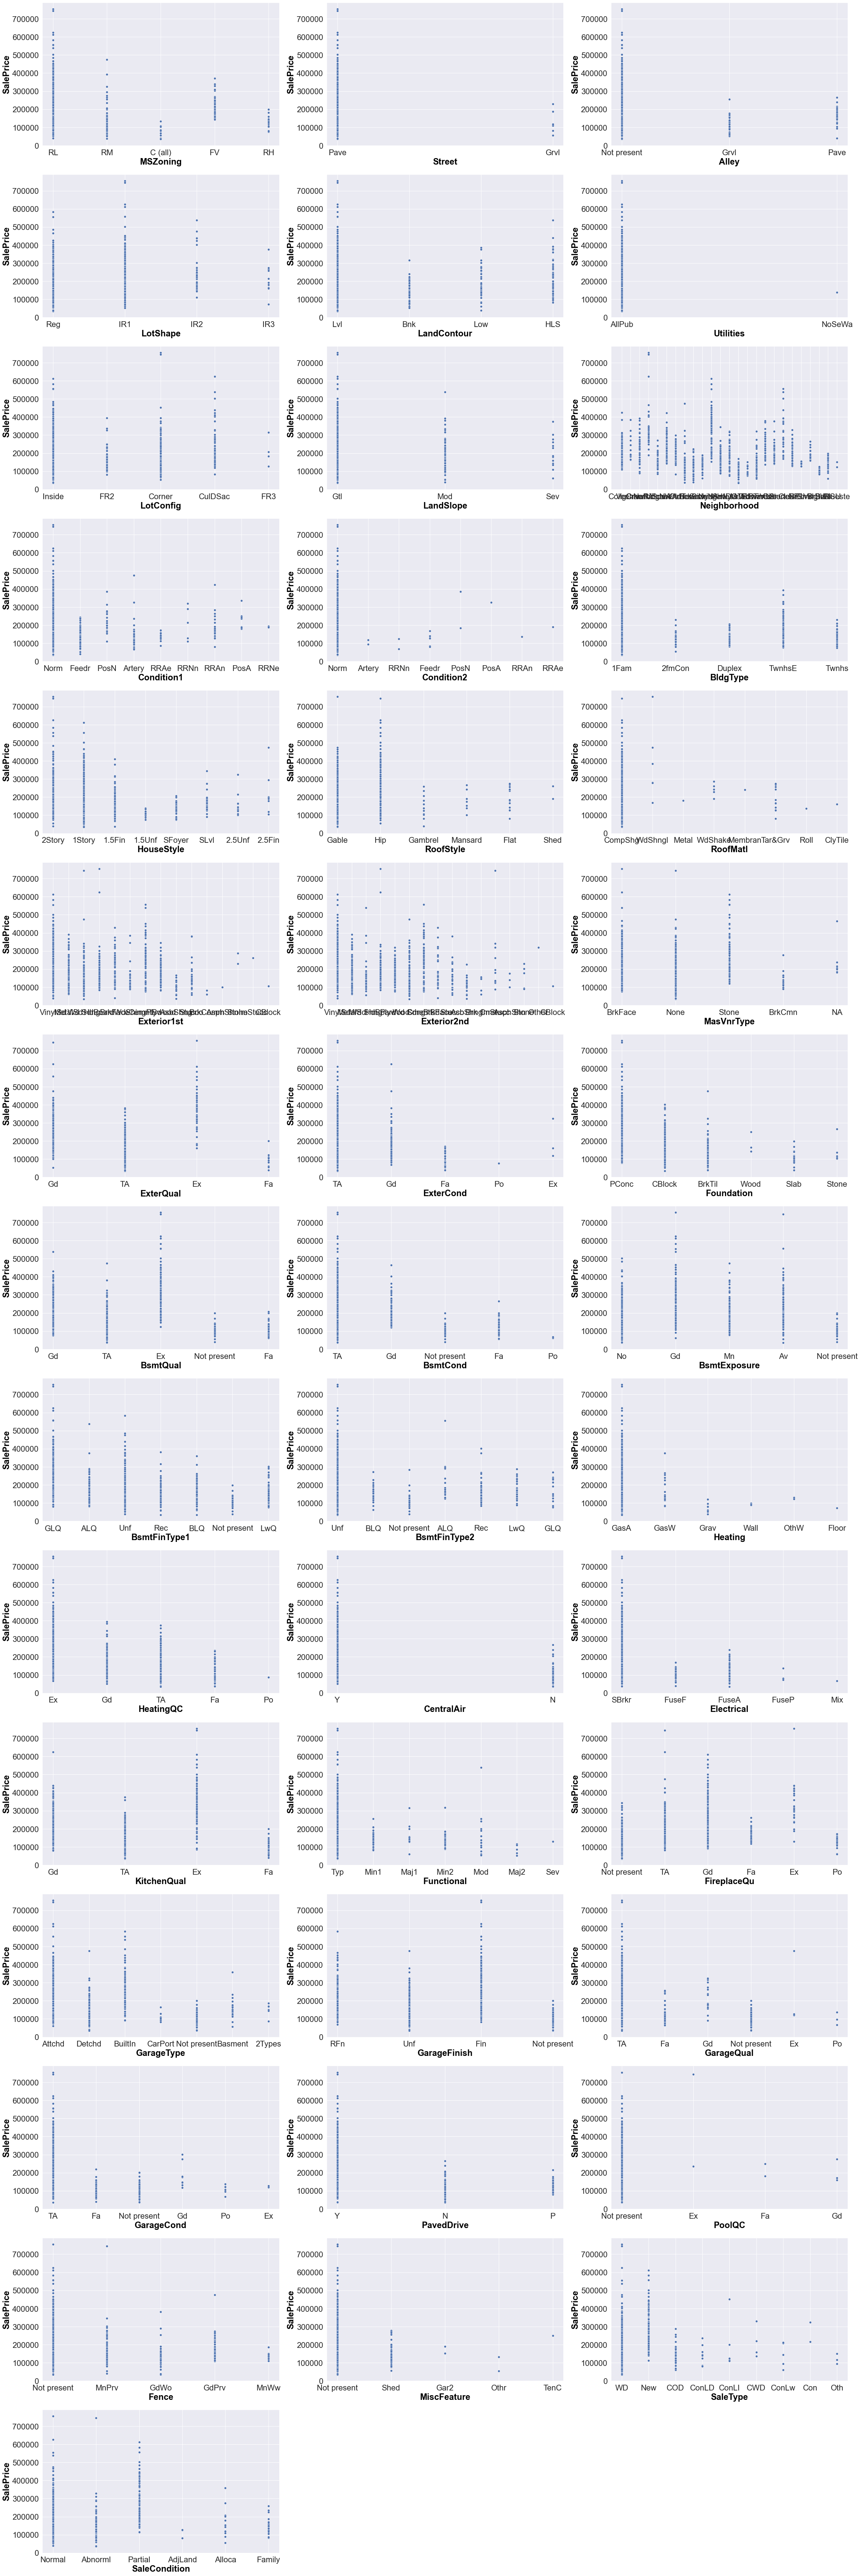

In [1567]:
plot_scattersubplots(object_cols, 'SalePrice', main_df, fig_size=(40, 130))

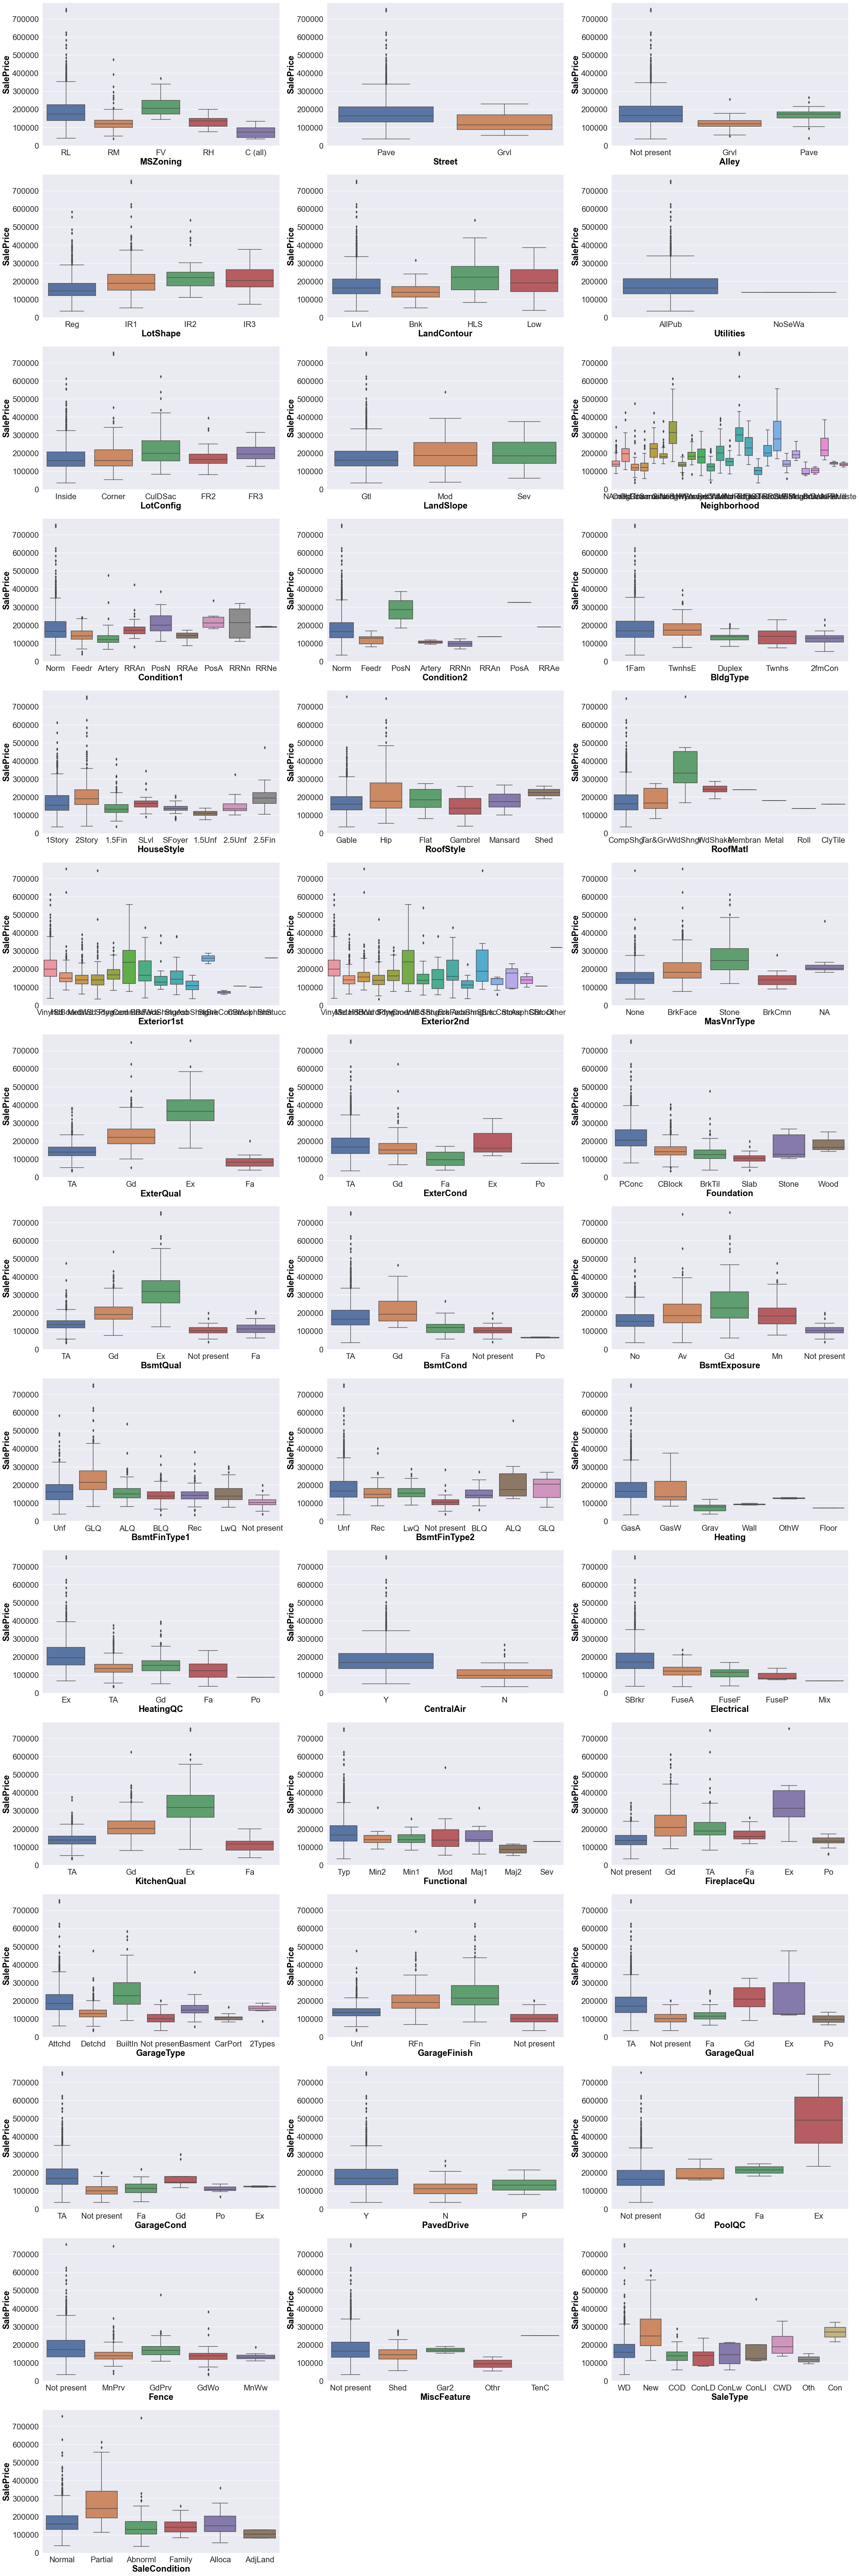

In [1568]:
plot_boxsubplots(object_cols, 'SalePrice', data=main_df, fig_size=(40, 130))

#### Observations:
-  <font color='blue'>There are several outliers in the data however will not be treated as the scaling will help to reduce the effect of outliers</font>

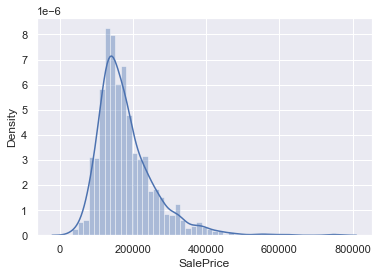

In [1569]:
plt.figure(figsize=(6,4))
sns.set(font_scale=1)
sns.distplot(main_df['SalePrice'])
plt.show()

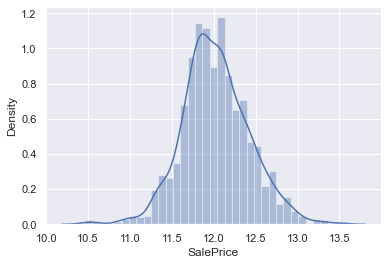

In [1570]:
#As the target variable is skewed, lets performn log to achieve normal distribution
main_df['SalePrice']=np.log(main_df['SalePrice'])

plt.figure(figsize=(6,4))
#sns.set(font_scale=1.5)
sns.distplot(main_df['SalePrice'])
plt.show()

#### Conclusion

- <font color='blue'>Univariate and bivariate information shows that the data is skewed and has several outliers.</font>
- <font color='blue'>The correlation metrix clearly shows the several variables have higher correlation mongst each other. However those are not cleared now as those will be cleaned in the modelling phase.</font>

## Step 4: Model building

In [1571]:
#The data size is limited hence choosing the 80/20 split.

X_train, X_test, y_train, y_test = train_test_split(main_df.drop('SalePrice',axis=1), 
                                                    main_df['SalePrice'], 
                                                    train_size=0.8, random_state=100)

In [1572]:
#Not distinguishing the date columns separately below to keep things simiple for EDA phase
object_cols = [col for col in X_train.columns if is_object_dtype(X_train[col])]
numeric_cols = [col for col in X_train.columns if is_numeric_dtype(X_train[col])]
date_cols = [col for col in X_train.columns if is_datetime64_ns_dtype(X_train[col])]

print('==============================Object columns - ' + str(len(object_cols)) + '=====================================')
print(str(object_cols))
print('===============================Numeric columns - ' + str(len(numeric_cols)) + '====================================')
print(str(numeric_cols))
print('===============================Date columns - ' + str(len(date_cols)) + '============================================')
print(str(date_cols))

==============================Object columns - 43=====================================
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
===============================Numeric columns - 30====================================
['MSSubClass', 'LotFrontage', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'Bedro

In [1573]:
#Converting the Date type columns to numeric to preprocess those columns and make suitable for model building.
for col in date_cols:
    main_df[col] = pd.to_numeric(main_df[col])
main_df[date_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   YearBuilt     1460 non-null   int64
 1   YearRemodAdd  1460 non-null   int64
 2   GarageYrBlt   1460 non-null   int64
 3   MoSold        1460 non-null   int64
 4   YrSold        1460 non-null   int64
dtypes: int64(5)
memory usage: 57.2 KB


In [1574]:
for col in date_cols:
    print(main_df[col].value_counts())

2006    67
2005    64
2004    54
2007    49
2003    45
        ..
1904     1
1898     1
1893     1
1882     1
2010     1
Name: YearBuilt, Length: 112, dtype: int64
1950    178
2006     97
2007     76
2005     73
2004     62
       ... 
2010      6
1983      5
1986      5
1952      5
1951      4
Name: YearRemodAdd, Length: 61, dtype: int64
-9223372036854775808    81
 1104537600000000000    65
 1136073600000000000    59
 1072915200000000000    53
 1041379200000000000    50
                        ..
-2019686400000000000     1
-2208988800000000000     1
-1356998400000000000     1
-1167609600000000000     1
-1956614400000000000     1
Name: GarageYrBlt, Length: 98, dtype: int64
6     253
7     234
5     204
4     141
8     122
3     106
10     89
11     79
9      63
12     59
1      58
2      52
Name: MoSold, dtype: int64
2009    338
2007    329
2006    314
2008    304
2010    175
Name: YrSold, dtype: int64


In [1575]:
#Pipeline to preprocess the categorical columns
categorical_pipeline = Pipeline([('CatSimpImputer',SimpleImputer(strategy='constant',fill_value='Not present')),
                                 ('OHE',OneHotEncoder(sparse=False,handle_unknown='ignore'))])

In [1576]:
categorical_pipeline.fit(X_train[object_cols])

Pipeline(steps=[('CatSimpImputer',
                 SimpleImputer(fill_value='Not present', strategy='constant')),
                ('OHE', OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [1577]:
#Pipeline to preprocess the numerical columns
numerical_pipeline=Pipeline([('NumSimpImputer',SimpleImputer(strategy='median')), 
                             ('NumScaling',RobustScaler())])

In [1578]:
date_pipeline=Pipeline([('DateSimpImputer',SimpleImputer(strategy='median')), 
                        ('DateScaling',RobustScaler())])

In [1579]:
column_transfer=ColumnTransformer([
    ('Numerical_pipeline',numerical_pipeline,numeric_cols),
    ('Categorical_pipeline',categorical_pipeline,object_cols),
    ('Date_pipeline',date_pipeline,date_cols) 
],remainder='drop')

In [1580]:
#creating a list which includes all the columns after the data pre-processing: numerical & one hot encoded categorical columns
all_cols=numeric_cols.copy()
all_cols.extend(date_cols)
all_cols.extend(column_transfer.transformers[1][1].named_steps['OHE'].get_feature_names(object_cols))

In [1581]:
#Cross validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

In [1582]:
#LR pipeline 
lm = LinearRegression()
#rfe = RFE(lm)
linear=Pipeline([('Column_Transfer',column_transfer),
                 ('lm',lm)])

### We are not using the RFE as with Grid search the more number of columns the output was getting penalized by time factor.

In [1583]:
linear_model = GridSearchCV(estimator = linear, 
                            param_grid=[{'lm__fit_intercept':[True]}],
                            scoring= 'r2', 
                            cv =folds, 
                            verbose = 1,
                            return_train_score=True) 

linear_model.fit(X_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=Pipeline(steps=[('Column_Transfer',
                                        ColumnTransformer(transformers=[('Numerical_pipeline',
                                                                         Pipeline(steps=[('NumSimpImputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('NumScaling',
                                                                                          RobustScaler())]),
                                                                         ['MSSubClass',
                                                                          'LotFrontage',
                                                                          'OverallQual',
                                                                          'OverallCond',
                                                                          'MasVnrArea',
                                                                          'BsmtFinSF1',
                                                                          'Bsmt...
                                                                          'Heating',
                                                                          'HeatingQC',
                                                                          'CentralAir',
                                                                          'Electrical', ...]),
                                                                        ('Date_pipeline',
                                                                         Pipeline(steps=[('DateSimpImputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('DateScaling',
                                                                                          RobustScaler())]),
                                                                         ['YearBuilt',
                                                                          'YearRemodAdd',
                                                                          'GarageYrBlt',
                                                                          'MoSold',
                                                                          'YrSold'])])),
                                       ('lm', LinearRegression())]),
             param_grid=[{'lm__fit_intercept': [True]}],
             return_train_score=True, scoring='r2', verbose=1)

In [1584]:
pd.DataFrame(linear_model.cv_results_,
             columns=['params','mean_test_score','mean_train_score','rank_test_score']).sort_values('rank_test_score').style.background_gradient(cmap='Greens')

In [1585]:
#Pipeline for Ridge & Lasso 
ridge=make_pipeline(column_transfer,Ridge())
lasso=make_pipeline(column_transfer,Lasso())

In [1586]:
ridge_model = GridSearchCV(estimator = ridge, 
                        param_grid = [{'ridge__alpha': [0.0005,.001,0.005,0.001, 0.05,0.1,0.5,1,1.5,5,10,50,100,200,500]}], 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 

ridge_model.fit(X_train,y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('Numerical_pipeline',
                                                                         Pipeline(steps=[('NumSimpImputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('NumScaling',
                                                                                          RobustScaler())]),
                                                                         ['MSSubClass',
                                                                          'LotFrontage',
                                                                          'OverallQual',
                                                                          'OverallCond',
                                                                          'MasVnrArea',
                                                                          'BsmtFinSF1',
                                                                          'Bs...
                                                                          'Electrical', ...]),
                                                                        ('Date_pipeline',
                                                                         Pipeline(steps=[('DateSimpImputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('DateScaling',
                                                                                          RobustScaler())]),
                                                                         ['YearBuilt',
                                                                          'YearRemodAdd',
                                                                          'GarageYrBlt',
                                                                          'MoSold',
                                                                          'YrSold'])])),
                                       ('ridge', Ridge())]),
             param_grid=[{'ridge__alpha': [0.0005, 0.001, 0.005, 0.001, 0.05,
                                           0.1, 0.5, 1, 1.5, 5, 10, 50, 100,
                                           200, 500]}],
             return_train_score=True, scoring='r2', verbose=1)

In [1587]:
ridge_model.best_params_

{'ridge__alpha': 5}

In [1588]:
pd.DataFrame(ridge_model.cv_results_,
             columns=['params','mean_test_score','mean_train_score','rank_test_score']).sort_values('rank_test_score').style.background_gradient(cmap='Greens')

In [1589]:
lasso_model = GridSearchCV(estimator = lasso, 
                           param_grid = [{'lasso__alpha': [0,0.0005,.001,0.005,0.01, 0.05,0.1,0.5,1,1.5]}], 
                           scoring= 'r2', 
                           cv = folds, 
                           verbose = 1,
                           return_train_score=True) 
lasso_model.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('Numerical_pipeline',
                                                                         Pipeline(steps=[('NumSimpImputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('NumScaling',
                                                                                          RobustScaler())]),
                                                                         ['MSSubClass',
                                                                          'LotFrontage',
                                                                          'OverallQual',
                                                                          'OverallCond',
                                                                          'MasVnrArea',
                                                                          'BsmtFinSF1',
                                                                          'Bs...
                                                                          'CentralAir',
                                                                          'Electrical', ...]),
                                                                        ('Date_pipeline',
                                                                         Pipeline(steps=[('DateSimpImputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('DateScaling',
                                                                                          RobustScaler())]),
                                                                         ['YearBuilt',
                                                                          'YearRemodAdd',
                                                                          'GarageYrBlt',
                                                                          'MoSold',
                                                                          'YrSold'])])),
                                       ('lasso', Lasso())]),
             param_grid=[{'lasso__alpha': [0, 0.0005, 0.001, 0.005, 0.01, 0.05,
                                           0.1, 0.5, 1, 1.5]}],
             return_train_score=True, scoring='r2', verbose=1)

In [1590]:
lasso_model.best_params_

{'lasso__alpha': 0.0005}

In [1591]:
pd.DataFrame(lasso_model.cv_results_,
             columns=['params','mean_test_score','mean_train_score','rank_test_score']).sort_values('rank_test_score').style.background_gradient(cmap='Greens')

In [1592]:
coef=pd.DataFrame()
coef['columns']=all_cols
coef['lasso']=lasso_model.best_estimator_.named_steps['lasso'].coef_
coef['ridge']=ridge_model.best_estimator_.named_steps['ridge'].coef_
coef.sort_values(['columns'],ascending=False).style.background_gradient(cmap='Greens')

## Step 4.1: Model evaluation

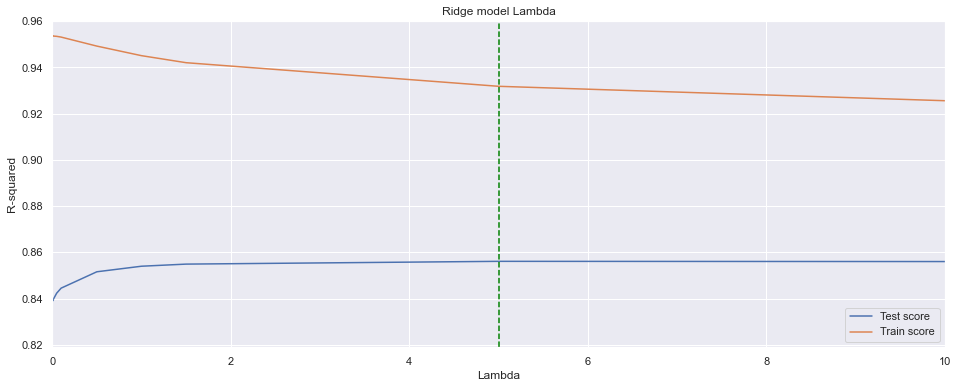

In [1593]:
#Ridge: Lambda Vs r-squared(mean)
ridge_cv=pd.DataFrame(ridge_model.cv_results_)

plt.figure(figsize=(16,6))

plt.plot(ridge_cv["param_ridge__alpha"], ridge_cv["mean_test_score"])
plt.plot(ridge_cv["param_ridge__alpha"], ridge_cv["mean_train_score"])
plt.xlabel('Lambda')
plt.ylabel('R-squared')
plt.xlim(0,10)
plt.axvline(5, color ="green", linestyle ="--")
plt.title("Ridge model Lambda")
plt.legend(['Test score', 'Train score'], loc='lower right')
plt.show()

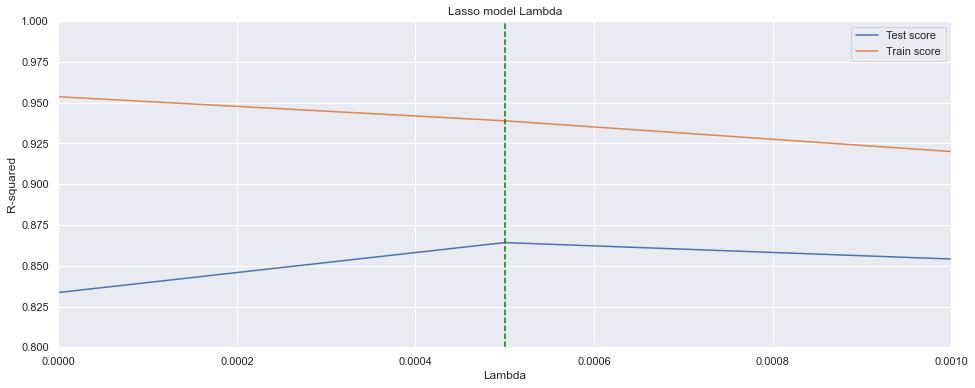

In [1594]:
#Lasso: Lambda Vs r-squared(mean)
lasso_cv=pd.DataFrame(lasso_model.cv_results_)

plt.figure(figsize=(16,6))

plt.plot(lasso_cv["param_lasso__alpha"], lasso_cv["mean_test_score"])
plt.plot(lasso_cv["param_lasso__alpha"], lasso_cv["mean_train_score"])
plt.xlabel('Lambda')
plt.ylabel('R-squared')
plt.title("Lasso model Lambda")
plt.xlim(0,.001)
plt.ylim(.8,1)
plt.axvline(0.0005, color ="green", linestyle ="--")
plt.legend(['Test score', 'Train score'], loc='upper right')

In [1595]:
ridge_05=Pipeline([
    ('Column_Transfer', column_transfer),('Ridge05', Ridge(alpha=5))
])
ridge_10=Pipeline([
    ('Column_Transfer', column_transfer),('Ridge10', Ridge(alpha=10))
])
lasso_0005=Pipeline([
    ('Column_Transfer', column_transfer),('Lasso0005', Lasso(alpha=0.0005))
])
lasso_001=Pipeline([
    ('Column_Transfer', column_transfer),('Lasso001', Lasso(alpha=0.001))
])

In [1596]:
ridge_05.fit(X_train,y_train)
ridge_10.fit(X_train,y_train)
lasso_0005.fit(X_train,y_train)
lasso_001.fit(X_train,y_train)

Pipeline(steps=[('Column_Transfer',
                 ColumnTransformer(transformers=[('Numerical_pipeline',
                                                  Pipeline(steps=[('NumSimpImputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('NumScaling',
                                                                   RobustScaler())]),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'OverallQual', 'OverallCond',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'LowQualFinSF',
                                                   'Gr...
                                                   'Foundation', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', ...]),
                                                 ('Date_pipeline',
                                                  Pipeline(steps=[('DateSimpImputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('DateScaling',
                                                                   RobustScaler())]),
                                                  ['YearBuilt', 'YearRemodAdd',
                                                   'GarageYrBlt', 'MoSold',
                                                   'YrSold'])])),
                ('Lasso001', Lasso(alpha=0.001))])

In [1597]:
quickview_df=pd.DataFrame((ridge_05.named_steps['Ridge05'].coef_),columns=['Ridge_05'])
quickview_df['Ridge_10']=ridge_10.named_steps['Ridge10'].coef_
quickview_df['Lasso_0005']=lasso_0005.named_steps['Lasso0005'].coef_
quickview_df['Lasso_001']=lasso_001.named_steps['Lasso001'].coef_
quickview_df['Variables']=all_cols
quickview_df.sort_values(['Lasso_001','Lasso_0005','Ridge_10','Ridge_05'],ascending=False).style.background_gradient(axis=0)

for i in ['Lasso_001','Lasso_0005','Ridge_10','Ridge_05']:
    print(quickview_df.sort_values(i,ascending=False).head(10)[['Variables',i]])
    print('-'*50)

                 Variables  Lasso_001
12               GrLivArea       0.15
2              OverallQual       0.11
64    Neighborhood_Blueste       0.10
295  SaleCondition_AdjLand       0.07
74    Neighborhood_Mitchel       0.07
85    Neighborhood_StoneBr       0.06
130       RoofMatl_WdShake       0.05
187            BsmtCond_Gd       0.05
13            BsmtFullBath       0.05
224       Electrical_FuseF       0.05
--------------------------------------------------
                 Variables  Lasso_0005
12               GrLivArea        0.16
64    Neighborhood_Blueste        0.12
2              OverallQual        0.09
295  SaleCondition_AdjLand        0.08
80    Neighborhood_OldTown        0.07
130       RoofMatl_WdShake        0.07
74    Neighborhood_Mitchel        0.06
224       Electrical_FuseF        0.06
187            BsmtCond_Gd        0.06
234        Functional_Maj2        0.06
--------------------------------------------------
                Variables  Ridge_10
64   Neighborho

In [1598]:
y_pred_train = linear_model.predict(X_train)
y_pred_test = linear_model.predict(X_test)

metric1 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print('R2 train score: ',r2_train_lr)
metric1.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print('R2 test score: ',r2_test_lr)
metric1.append(r2_test_lr)

r2_diff = r2_train_lr - r2_test_lr
print('R2 train/test diff: ',r2_diff)
metric1.append(r2_diff)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print('RSS Train: ',rss1_lr)
metric1.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print('RSS Test: ',rss2_lr)
metric1.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print('MSE Train: ',mse_train_lr)
metric1.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print('MSE Test: ',mse_test_lr)
metric1.append(mse_test_lr**0.5)


n = X_train.shape[0]
p = X_train.shape[1]
adjusted_r2_train = 1-((1-r2_train_lr)*(n-1)/(n-p-1))
print('Adjusted R2 Train: ',adjusted_r2_train)
metric1.append(adjusted_r2_train)

n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2_test = 1-((1-r2_test_lr)*(n-1)/(n-p-1))
print('Adjusted R2 Test: ',adjusted_r2_test)
metric1.append(adjusted_r2_test)

R2 train score:  0.9503331575206162
R2 test score:  -35056893044.637764
R2 train/test diff:  35056893045.5881
RSS Train:  9.065541897603905
RSS Test:  1762350402970.436
MSE Train:  0.007761594090414303
MSE Test:  6035446585.515192
Adjusted R2 Train:  0.9467757528251232
Adjusted R2 Test:  -47894628526.138916


In [1599]:
y_pred_train = ridge_05.predict(X_train)
y_pred_test = ridge_05.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print('R2 train score: ',r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print('R2 test score: ',r2_test_lr)
metric2.append(r2_test_lr)

r2_diff = r2_train_lr - r2_test_lr
print('R2 train/test diff: ',r2_diff)
metric2.append(r2_diff)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print('RSS Train: ',rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print('RSS Test: ',rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print('MSE Train: ',mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print('MSE Test: ',mse_test_lr)
metric2.append(mse_test_lr**0.5)

n = X_train.shape[0]
p = X_train.shape[1]
adjusted_r2_train = 1-((1-r2_train_lr)*(n-1)/(n-p-1))
print('Adjusted R2 Train: ',adjusted_r2_train)
metric2.append(adjusted_r2_train)

n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2_test = 1-((1-r2_test_lr)*(n-1)/(n-p-1))
print('Adjusted R2 Test: ',adjusted_r2_test)
metric2.append(adjusted_r2_test)

R2 train score:  0.9282841499859937
R2 test score:  0.8878590561157979
R2 train/test diff:  0.04042509387019588
RSS Train:  13.090082046067657
RSS Test:  5.637454448302877
MSE Train:  0.011207262025742857
MSE Test:  0.019306350850352316
Adjusted R2 Train:  0.9231474775331999
Adjusted R2 Test:  0.8467933583553857


In [1600]:
y_pred_train = ridge_10.predict(X_train)
y_pred_test = ridge_10.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print('R2 train score: ',r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print('R2 test score: ',r2_test_lr)
metric3.append(r2_test_lr)

r2_diff = r2_train_lr - r2_test_lr
print('R2 train/test diff: ',r2_diff)
metric3.append(r2_diff)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print('RSS Train: ',rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print('RSS Test: ',rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print('MSE Train: ',mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print('MSE Test: ',mse_test_lr)
metric3.append(mse_test_lr**0.5)

n = X_train.shape[0]
p = X_train.shape[1]
adjusted_r2_train = 1-((1-r2_train_lr)*(n-1)/(n-p-1))
print('Adjusted R2 Train: ',adjusted_r2_train)
metric3.append(adjusted_r2_train)

n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2_test = 1-((1-r2_test_lr)*(n-1)/(n-p-1))
print('Adjusted R2 Test: ',adjusted_r2_test)
metric3.append(adjusted_r2_test)

R2 train score:  0.9222221080945449
R2 test score:  0.8915522817693489
R2 train/test diff:  0.030669826325195992
RSS Train:  14.196568627629
RSS Test:  5.451791739678835
MSE Train:  0.012154596427764555
MSE Test:  0.018670519656434365
Adjusted R2 Train:  0.916651239803796
Adjusted R2 Test:  0.8518390328398147


In [1601]:
y_pred_train = lasso_001.predict(X_train)
y_pred_test = lasso_001.predict(X_test)

metric4 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print('R2 train score: ',r2_train_lr)
metric4.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print('R2 test score: ',r2_test_lr)
metric4.append(r2_test_lr)

r2_diff = r2_train_lr - r2_test_lr
print('R2 train/test diff: ',r2_diff)
metric4.append(r2_diff)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print('RSS Train: ',rss1_lr)
metric4.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print('RSS Test: ',rss2_lr)
metric4.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print('MSE Train: ',mse_train_lr)
metric4.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print('MSE Test: ',mse_test_lr)
metric4.append(mse_test_lr**0.5)

n = X_train.shape[0]
p = X_train.shape[1]
adjusted_r2_train = 1-((1-r2_train_lr)*(n-1)/(n-p-1))
print('Adjusted R2 Train: ',adjusted_r2_train)
metric4.append(adjusted_r2_train)

n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2_test = 1-((1-r2_test_lr)*(n-1)/(n-p-1))
print('Adjusted R2 Test: ',adjusted_r2_test)
metric4.append(adjusted_r2_test)

R2 train score:  0.9107995715424083
R2 test score:  0.8880532030581944
R2 train/test diff:  0.022746368484213964
RSS Train:  16.281490449129716
RSS Test:  5.6276944578290315
MSE Train:  0.013939632233843936
MSE Test:  0.01927292622544189
Adjusted R2 Train:  0.9044105601377324
Adjusted R2 Test:  0.8470586013611952


In [1602]:
y_pred_train = lasso_0005.predict(X_train)
y_pred_test = lasso_0005.predict(X_test)

metric5 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print('R2 train score: ',r2_train_lr)
metric5.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print('R2 test score: ',r2_test_lr)
metric5.append(r2_test_lr)

r2_diff = r2_train_lr - r2_test_lr
print('R2 train/test diff: ',r2_diff)
metric5.append(r2_diff)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print('RSS Train: ',rss1_lr)
metric5.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print('RSS Test: ',rss2_lr)
metric5.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print('MSE Train: ',mse_train_lr)
metric5.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print('MSE Test: ',mse_test_lr)
metric5.append(mse_test_lr**0.5)

n = X_train.shape[0]
p = X_train.shape[1]
adjusted_r2_train = 1-((1-r2_train_lr)*(n-1)/(n-p-1))
print('Adjusted R2 Train: ',adjusted_r2_train)
metric5.append(adjusted_r2_train)

n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2_test = 1-((1-r2_test_lr)*(n-1)/(n-p-1))
print('Adjusted R2 Test: ',adjusted_r2_test)
metric5.append(adjusted_r2_test)

R2 train score:  0.9344025769151563
R2 test score:  0.8820927579419577
R2 train/test diff:  0.05230981897319853
RSS Train:  11.973303670297646
RSS Test:  5.927332900939435
MSE Train:  0.010251116156076752
MSE Test:  0.020299085277189845
Adjusted R2 Train:  0.92970413889806
Adjusted R2 Test:  0.8389154580333789


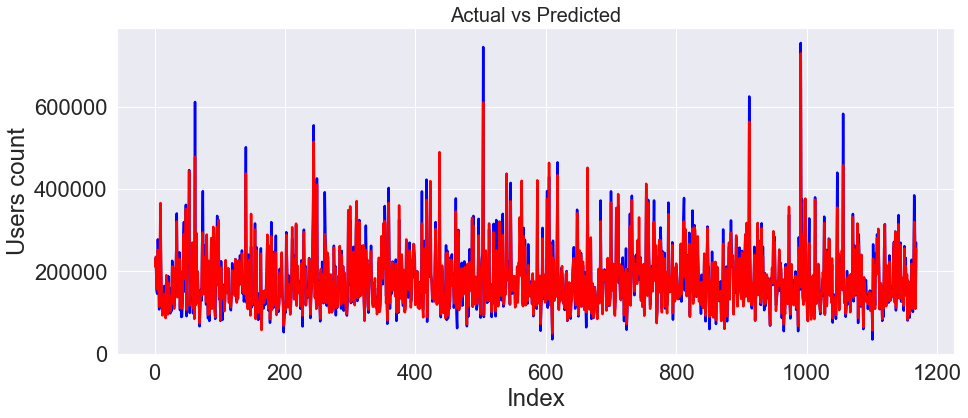

In [1603]:
#Actual vs Predicted
record_count = [i for i in range(1, y_pred_train.size+1, 1)]
plt.figure(figsize=(15, 6))
sns.set(font_scale=2)
sns.lineplot(record_count,np.exp(y_train), color="blue", linewidth=2.5, linestyle="-")
sns.lineplot(record_count,np.exp(y_pred_train), color="red",  linewidth=2.5, linestyle="-")
plt.title('Actual vs Predicted', fontsize=20)  
plt.xlabel('Index')                   
plt.ylabel('Users count')
plt.show()

<AxesSubplot:xlabel='Actual_SalePrice', ylabel='Predcited_SalePrice'>

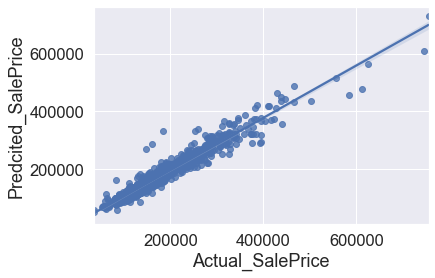

In [1604]:
#Actual House price will be inverse of log as the trained model used log for sale price

new_df=pd.DataFrame()
new_df['Actual_SalePrice']=np.exp(y_train)
new_df['Predcited_SalePrice']=np.exp(y_pred_train)

sns.set(font_scale=1.5)
sns.regplot(data=new_df,x='Actual_SalePrice',y='Predcited_SalePrice')

In [1605]:
lasso_001.named_steps['Lasso001'].coef_

array([-2.11733651e-02, -2.17455516e-03,  1.11941928e-01,  4.28690814e-02,
        3.21138580e-04,  4.19614780e-03,  4.21435345e-05, -0.00000000e+00,
        2.57267929e-02,  0.00000000e+00,  0.00000000e+00, -5.25165978e-05,
        1.45708951e-01,  5.25855436e-02,  0.00000000e+00,  1.72714886e-02,
        1.14383080e-02,  4.80205775e-03, -4.95120088e-03,  1.49854455e-02,
        1.46679522e-02,  5.01830983e-02,  9.43160400e-03,  1.60510294e-02,
        0.00000000e+00,  1.37221561e-04,  2.58650408e-04,  2.31815062e-04,
       -4.48698590e-04, -3.45324430e-06, -2.04971756e-01,  3.30839707e-03,
        0.00000000e+00,  0.00000000e+00, -7.42660971e-02, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -6.34855528e-03,
       -5.68606948e-02,  0.00000000e+00,  3.43344556e-03, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  2.75964960e-02,
       -0.00000000e+00, -

### Linear regression's assumption validation

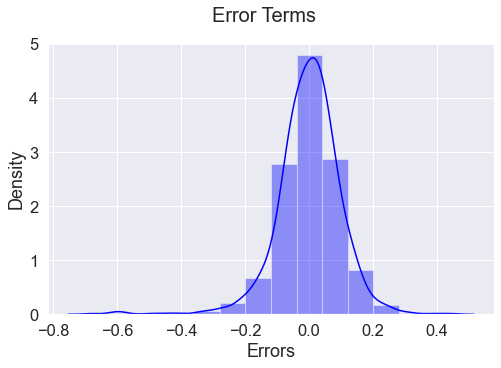

In [1606]:
# Plot: The histogram of the error terms-> to check if error terms are normally distributed
fig = plt.figure(figsize=(8,5))
res = y_train - y_pred_train
sns.distplot(res,bins=14,color="Blue")
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)  
plt.show()

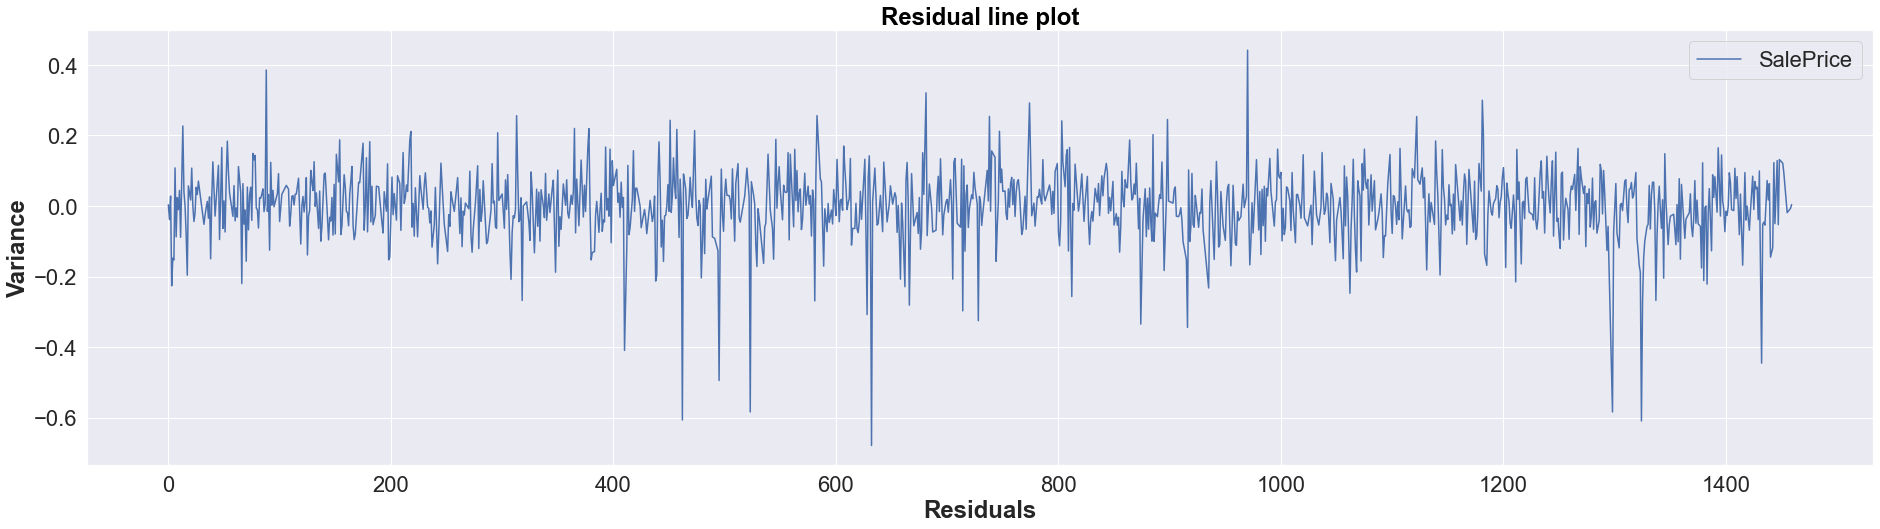

In [1607]:
#Plot: To check variance in error terms
plt.figure(figsize=(32,8))
sns.set(font_scale=2)
sns.lineplot(data=pd.DataFrame(res))
plt.xlabel('Residuals', fontweight='bold')
plt.ylabel('Variance', fontweight='bold')
plt.title('Residual line plot', color='black', fontweight='bold')
plt.show()

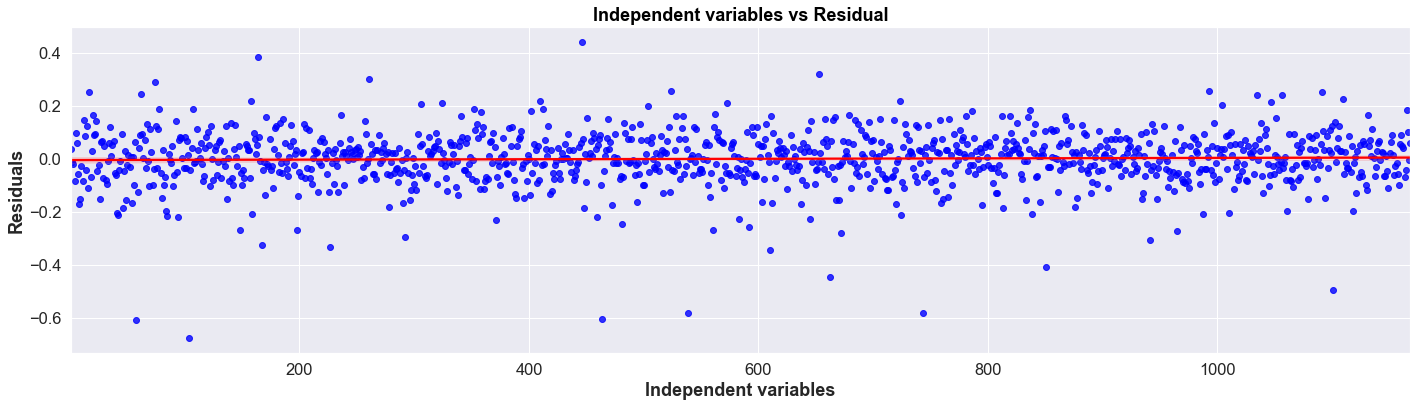

In [1608]:
#Plot: To check if error terms are independent to each other
plt.figure(figsize=(24,6))
sns.set(font_scale=1.5)
record_count = [i for i in range(1, X_train.shape[0]+1, 1)]
sns.regplot(x=record_count, y=res, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.xlabel('Independent variables', fontweight='bold')
plt.ylabel('Residuals', fontweight='bold')
plt.title('Independent variables vs Residual', color='black', fontweight='bold')
plt.show()

Text(0.5, 1.0, 'Dependent variables vs Residual')

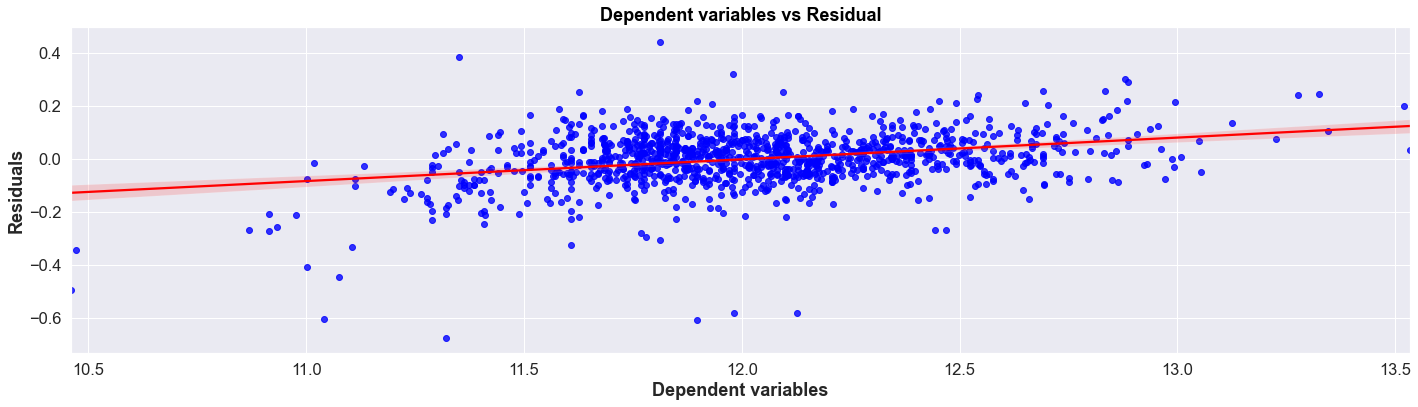

In [1609]:
#Plot: Dependent variables vs Residuals
plt.figure(figsize=(24,6))
sns.set(font_scale=1.5)
sns.regplot(x=y_train, y=res, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.xlabel('Dependent variables', fontweight='bold')
plt.ylabel('Residuals', fontweight='bold')
plt.title('Dependent variables vs Residual', color='black', fontweight='bold')

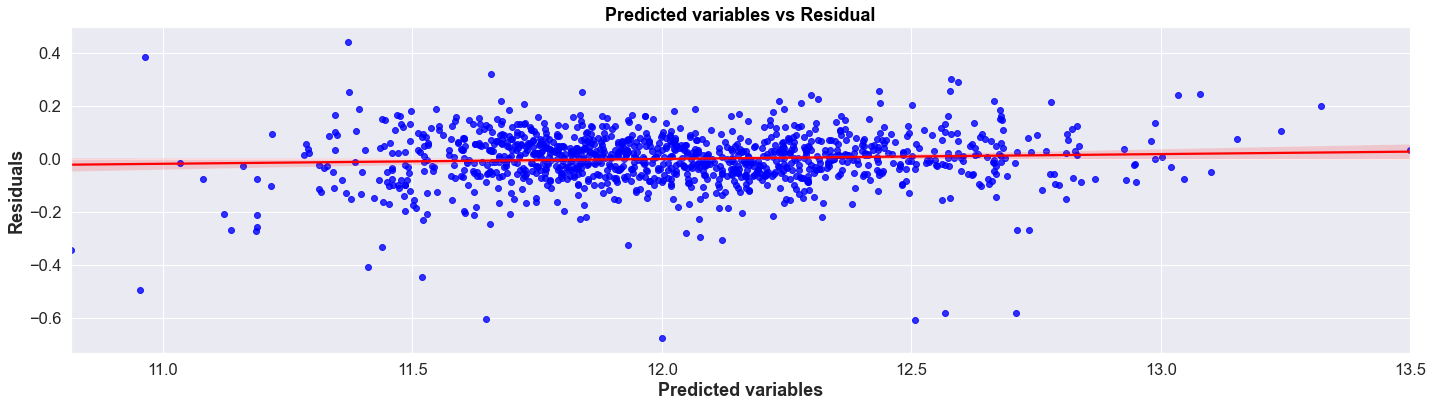

In [1610]:
#Plot: Variance in the error terms-> to check if error terms have constant variance
plt.figure(figsize=(24,6))
sns.set(font_scale=1.5)
sns.regplot(x=y_pred_train, y=res, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.xlabel('Predicted variables', fontweight='bold')
plt.ylabel('Residuals', fontweight='bold')
plt.title('Predicted variables vs Residual', color='black', fontweight='bold')
plt.show()

# Step 5: Conclusion

## Business Objective
- **<font color=blue>The model is created which will be used by the management to identify different variables affecting the housing prices. Below are the variables which could be part of the revenue growth strategy.</font>**

### Model conclusion
- <font color='brown'>The Mean R2 score with these optimal lambdas for train is 0.93 for Ridge & 0.94 for Lasso. 
It’s observed that the accuracy does not affect but the model interpretations become more challenging because of higher number of columns (around 300) in the data frame after the transformations. 
Ridge Regression can shrink the model coefficients close to zero and does not allow feature selection because it retains all the variables present in data. This makes the interpretability a substantial challenge and eventually making difficult to define the business strategies. 
Unlike ridge, Lasso regression shrinks the coefficient estimates to zero. Here the penalty term forces some coefficients to zero enabling the feature selection and reduces the curse of dimensionality. Hence the models generated with lasso are easy to interpret without affecting the accuracy.
-  From the business objective its clearly states that the company wants to know the variables that are significant in predicting the price of a house, and how well those variables describe the price of a house. 
Hence Lasso regression gives the significant variables that predict the price of house with much easier interpretability. Therefore, Lasso regression inclines more towards the business objective.
-  If the training and test score is within ~5% then you can say model is generalizable as the model is able to identify the underlying pattern and behave as good as train data on test data as well.
A model Robustness depend on business objective how much accuracy you are looking for, like 80% and above or number of variables in the final model and the coefficient of the Predictors. Moreover, model should be created in such way that it can easily predict un-processed unseen test i.e., test data and shall yield good accuracy. Hence, concept of Pipelines and Column transformers has been used while building robust model.
-  <b>Implications</b>:
>-  Metrics for Lasso Model with Alpha= 0.0005 gives good implication. As seen the adjusted R2 score does not deviate much from r2 score for train and test which also strengthen the fact that model is robust and more generalized.
</font>


In [1611]:
Conclusion_model_df = pd.DataFrame((lasso_0005.named_steps['Lasso0005'].coef_),columns=['Lasso0005'])
Conclusion_model_df['Variables'] = all_cols
Conclusion_model_df = Conclusion_model_df[Conclusion_model_df['Lasso0005'] != 0.000]

#.sort_values('lasso_0005',ascending=False).style.background_gradient('RdYlGn').set_precision(4)

In [1612]:
Conclusion_model_df.head()

Lasso0005    Variables
0      -0.01   MSSubClass
1       0.00  LotFrontage
2       0.09  OverallQual
3       0.04  OverallCond
4       0.00   MasVnrArea

#### Positive factors for pricing changes

In [1613]:
Conclusion_model_df[Conclusion_model_df['Lasso0005'] > 0.000]\
.sort_values('Lasso0005',ascending=False).style.background_gradient('tab20').set_precision(6)

#### Inversely impacting factors

In [1614]:
Conclusion_model_df[Conclusion_model_df['Lasso0005'] < 0.000]\
.sort_values('Lasso0005',ascending=False).style.background_gradient('tab20').set_precision(6)

In [1615]:
print('Total variables used for model are: ',len(all_cols))
print('Final variables recommended by model : ',Conclusion_model_df[Conclusion_model_df['Lasso0005']!=0.000].shape[0])

Total variables used for model are:  300
Final variables recommended by model :  119


# Assignment Part II 

## Question and Answer

- <font color='blue'><b>Question 1: What is the optimal value of alpha for ridge and lasso regression? What will be the changes in the model if you choose double the value of alpha for both ridge and lasso? What will be the most important predictor variables after the change is implemented?</b></font>

In [1616]:
ridge_model.best_params_

{'ridge__alpha': 5}

In [1617]:
lasso_model.best_params_

{'lasso__alpha': 0.0005}

In [1618]:
pd.DataFrame(ridge_model.cv_results_,
             columns=['params','mean_test_score','mean_train_score','rank_test_score'])\
.sort_values('rank_test_score')[:2].style.background_gradient(cmap='Greens')

In [1619]:
pd.DataFrame(lasso_model.cv_results_,
             columns=['params','mean_test_score','mean_train_score','rank_test_score'])\
.sort_values('rank_test_score')[:2].style.background_gradient(cmap='Greens')

In [1620]:
metric1

[0.9503331575206162,
 -35056893044.637764,
 35056893045.5881,
 9.065541897603905,
 1762350402970.436,
 0.08809990970718587,
 77688.13671028023,
 0.9467757528251232,
 -47894628526.138916]

In [1621]:
# Creating a table which contain all the metrics
lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)', 'R2 train/test diff', 'RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)', 'Adjusted R2 (Train)', 'Adjusted R2 (Test)'], 
        'Linear Regression': metric1
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric1 = pd.Series(metric2, name = 'Ridge Regression 5')
ls_metric1 = pd.Series(metric5, name = 'Lasso Regression 0.0005')
rg_metric2 = pd.Series(metric3, name = 'Ridge Regression 10')
ls_metric2 = pd.Series(metric4, name = 'Lasso Regression 0.001')

final_metric = pd.concat([lr_metric, rg_metric1, rg_metric2, ls_metric1, ls_metric2], axis = 1)

final_metric.style.background_gradient('Greens')

In [1622]:
quickview_df=pd.DataFrame((ridge_05.named_steps['Ridge05'].coef_),columns=['Ridge_05'])
quickview_df['Ridge_10']=ridge_10.named_steps['Ridge10'].coef_
quickview_df['Lasso_0005']=lasso_0005.named_steps['Lasso0005'].coef_
quickview_df['Lasso_001']=lasso_001.named_steps['Lasso001'].coef_
quickview_df['Variables']=all_cols
quickview_df.sort_values(['Lasso_001','Lasso_0005','Ridge_10','Ridge_05'],ascending=False).style.background_gradient(axis=0)

for i in ['Lasso_001','Lasso_0005','Ridge_10','Ridge_05']:
    print(quickview_df.sort_values(i,ascending=False).head(10)[['Variables',i]])
    print('-'*50)

                 Variables  Lasso_001
12               GrLivArea       0.15
2              OverallQual       0.11
64    Neighborhood_Blueste       0.10
295  SaleCondition_AdjLand       0.07
74    Neighborhood_Mitchel       0.07
85    Neighborhood_StoneBr       0.06
130       RoofMatl_WdShake       0.05
187            BsmtCond_Gd       0.05
13            BsmtFullBath       0.05
224       Electrical_FuseF       0.05
--------------------------------------------------
                 Variables  Lasso_0005
12               GrLivArea        0.16
64    Neighborhood_Blueste        0.12
2              OverallQual        0.09
295  SaleCondition_AdjLand        0.08
80    Neighborhood_OldTown        0.07
130       RoofMatl_WdShake        0.07
74    Neighborhood_Mitchel        0.06
224       Electrical_FuseF        0.06
187            BsmtCond_Gd        0.06
234        Functional_Maj2        0.06
--------------------------------------------------
                Variables  Ridge_10
64   Neighborho

-  <font color='blue'><b>Question 2: You have determined the optimal value of lambda for ridge and lasso regression during the assignment. Now, which one will you choose to apply and why?</b></font>

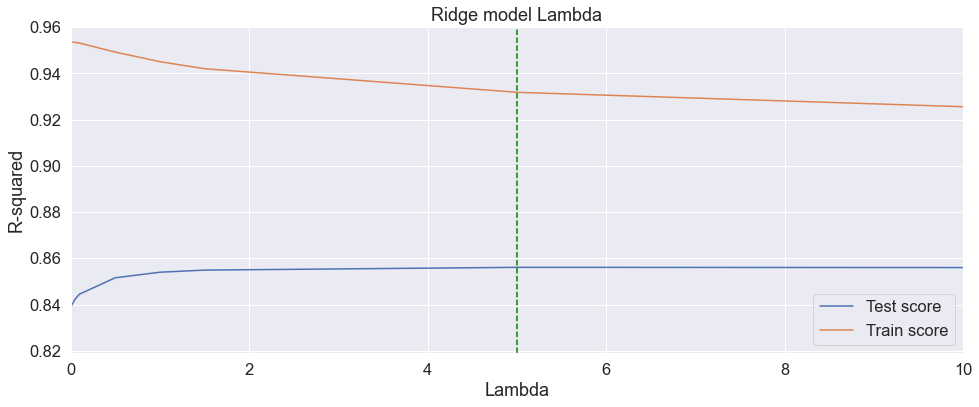

In [1623]:
ridge_cv=pd.DataFrame(ridge_model.cv_results_)

plt.figure(figsize=(16,6))

plt.plot(ridge_cv["param_ridge__alpha"], ridge_cv["mean_test_score"])
plt.plot(ridge_cv["param_ridge__alpha"], ridge_cv["mean_train_score"])
plt.xlabel('Lambda')
plt.ylabel('R-squared')
plt.xlim(0,10)
plt.axvline(5, color ="green", linestyle ="--")
plt.title("Ridge model Lambda")
plt.legend(['Test score', 'Train score'], loc='lower right')
plt.show()

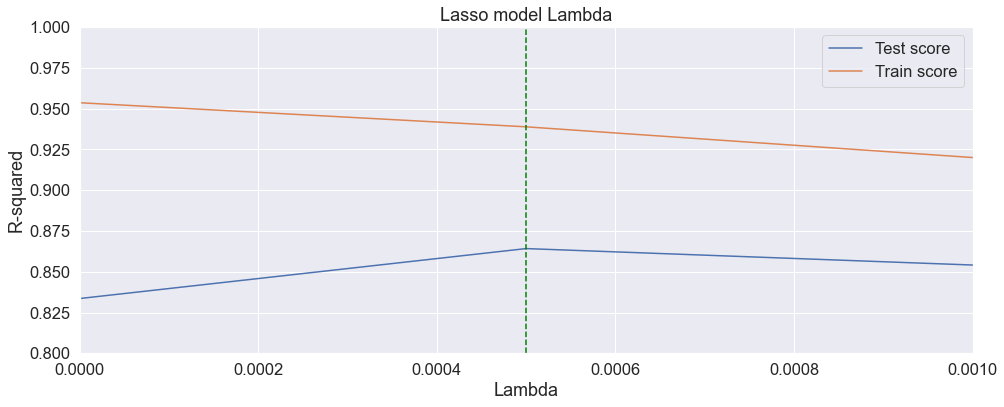

In [1624]:
lasso_cv=pd.DataFrame(lasso_model.cv_results_)

plt.figure(figsize=(16,6))

plt.plot(lasso_cv["param_lasso__alpha"], lasso_cv["mean_test_score"])
plt.plot(lasso_cv["param_lasso__alpha"], lasso_cv["mean_train_score"])
plt.xlabel('Lambda')
plt.ylabel('R-squared')
plt.title("Lasso model Lambda")
plt.xlim(0,.001)
plt.ylim(.8,1)
plt.axvline(0.0005, color ="green", linestyle ="--")
plt.legend(['Test score', 'Train score'], loc='upper right')

- <font color='blue'><b>Question 3: After building the model, you realised that the five most important predictor variables in the lasso model are not available in the incoming data. You will now have to create another model excluding the five most important predictor variables. Which are the five most important predictor variables now?</b></font>

In [1625]:
Conclusion_model_df.sort_values(by='Lasso0005',ascending=False).head(5).style.background_gradient('Greens')

In [1626]:
top5=['GrLivArea','Neighborhood_Blueste','OverallQual','SaleCondition_AdjLand','Neighborhood_OldTown']

In [1627]:
new_df=pd.DataFrame(column_transfer.fit_transform(X_train),columns=all_cols).drop(top5,axis=1)

In [1628]:
lasso_2=Lasso(alpha=0.0005)
lasso_2.fit(new_df,y_train)
lasso_df=pd.DataFrame(lasso_2.coef_,columns=['coeff'])
lasso_df['columns']=new_df.columns
lasso_df.sort_values('coeff',ascending=False).head(5).style.background_gradient('Greens')

-  <font color='blue'><b>Question 4: How can you make sure that a model is robust and generalisable? What are the implications of the same for the accuracy of the model and why?</b></font>

In [1629]:
lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)', 'R2 train/test diff', 'RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)', 'Adjusted R2 (Train)', 'Adjusted R2 (Test)'], 
        'Linear Regression': metric1
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric1 = pd.Series(metric2, name = 'Ridge Regression 5')
ls_metric1 = pd.Series(metric5, name = 'Lasso Regression 0.0005')
rg_metric2 = pd.Series(metric3, name = 'Ridge Regression 10')
ls_metric2 = pd.Series(metric4, name = 'Lasso Regression 0.001')

final_metric = pd.concat([lr_metric, rg_metric1, rg_metric2, ls_metric1, ls_metric2], axis = 1)

final_metric.style.background_gradient('Greens')